# Evaluation of the equilibrium runs
Model output produced by the `equlibrium_run.py` script.

In [1]:
# import section
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Read the output of the VAS model.

In [3]:
# decide which mb model to use
use_random = False

In [4]:
if use_random:
    # specify working directories
    wdir = '/Users/oberrauch/work/master/working_directories/equilibrium_vas_wdir/'
    # specify file path
    fpath = os.path.join(wdir, 'run_output_random_vas.nc')
    # load dataset
    ds_vas = xr.open_dataset(fpath)
    # specify file path
    fpath = os.path.join(wdir, 'normalized_output_random_vas.nc')
    # load dataset
    ds_vas_norm = xr.open_dataset(fpath)
else:
    # specify working directories
    wdir = '/Users/oberrauch/work/master/working_directories/equilibrium_vas_wdir/'
    # specify file path
    fpath = os.path.join(wdir, 'run_output_constant_vas.nc')
    # load dataset
    ds_vas = xr.open_dataset(fpath)
    # specify file path
    fpath = os.path.join(wdir, 'normalized_output_constant_vas.nc')
    # load dataset
    ds_vas_norm = xr.open_dataset(fpath)

Read the output of the flowline model.

In [5]:
if use_random:
    # specify working directories
    wdir = '/Users/oberrauch/work/master/working_directories/equilibrium_fl_wdir/'
    # specify file path
    fpath = os.path.join(wdir, 'run_output_random_fl.nc')
    # load dataset
    ds_fl = xr.open_dataset(fpath)
    # specify file path
    fpath = os.path.join(wdir, 'normalized_output_random_fl.nc')
    # load dataset
    ds_fl_norm = xr.open_dataset(fpath)
else:
    # specify working directories
    wdir = '/Users/oberrauch/work/master/working_directories/equilibrium_fl_wdir/'
    # specify file path
    fpath = os.path.join(wdir, 'run_output_constant_fl.nc')
    # load dataset
    ds_fl = xr.open_dataset(fpath)
    # specify file path
    fpath = os.path.join(wdir, 'normalized_output_constant_fl.nc')
    # load dataset
    ds_fl_norm = xr.open_dataset(fpath)

Combine both dataset, with model as new coordinate.

In [6]:
# create a single dataset
ds = xr.concat([ds_vas, ds_fl], 'model')
ds_norm = xr.concat([ds_vas_norm, ds_fl_norm], 'model')

Define some colors...

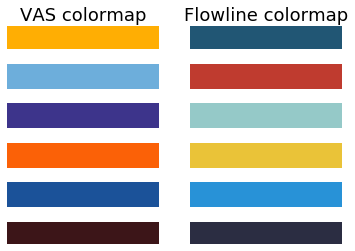

In [210]:
# define color cycles
vas_cycle = ['#FFAE03', '#6DAEDB', '#3D348B', '#FB6107', '#1B5299', '#3C1518']
fl_cycle = ['#215674', '#BF3B2F', '#95C9C8', '#EAC338', '#2892D7', '#2B2D42']
             
fig, ax = plt.subplots(1,2)
for i in np.arange(6):
    ax[0].axhline(i, c=vas_cycle[i], lw='25')
    ax[1].axhline(i, c=fl_cycle[i], lw='25')

ax[0].set_title('VAS colormap', fontsize=18)
ax[1].set_title('Flowline colormap', fontsize=18)
    
for ax_ in ax:
    ax_.invert_yaxis()
    ax_.axis('off')

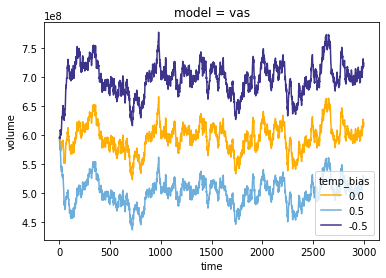

In [8]:
# plot vas volume change
fig, ax = plt.subplots(1, 1)
ax.set_prop_cycle('color', vas_cycle)
ds.sel(model='vas').volume.plot.line(x='time')

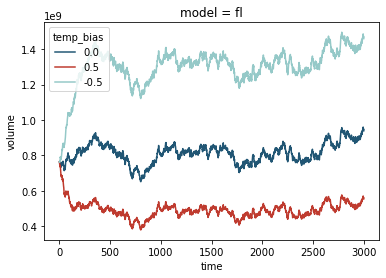

In [9]:
# plot flowline volume change
fig, ax = plt.subplots(1, 1)
ax.set_prop_cycle('color', fl_cycle)
ds.sel(model='fl').volume.plot.line(x='time')

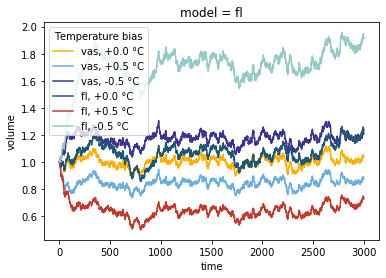

In [10]:
# plot relative volume change
fig, ax = plt.subplots(1, 1)
# vas model
ax.set_prop_cycle('color', vas_cycle)
handles_vas = ds_norm.sel(model='vas').volume.plot(hue='temp_bias', ax=ax, add_legend=False)
labels_vas = ['vas, {:+.1f} °C'.format(bias) for bias in ds_norm.temp_bias.values]
# flowline model
ax.set_prop_cycle('color', fl_cycle)
handles_fl = ds_norm.sel(model='fl').volume.plot(hue='temp_bias', ax=ax, add_legend=False)
labels_fl = ['fl, {:+.1f} °C'.format(bias) for bias in ds_norm.temp_bias.values]
ax.legend(handles_vas+handles_fl, labels_vas+labels_fl, title='Temperature bias')

### Time series

In [11]:
def plot_time_series(ds, var, title='', suptitle='', normalized=False):
    # plot relative volume change
    fig, [ax0, ax1] = plt.subplots(1, 2, figsize=[10, 5])

    # flowline model
    ds.sel(model='fl')[var].plot(hue='temp_bias', ax=ax0, add_legend=False, color='lightgray', lw=0.5)
    # vas model
    ax0.set_prop_cycle('color', vas_cycle)
    handles_vas = ds.sel(model='vas')[var].plot(hue='temp_bias', ax=ax0, add_legend=False)
    labels_vas = ['{:+.1f} °C'.format(bias) for bias in ds.temp_bias.values]
    
    # set axes limits
    ax0.set_xlim([ds.time.min(), ds.time.max()])
    ylim = ax0.get_ylim()
    ax0.set_ylim([ylim[0]*0.5, ylim[1]])
    
    # title, labels, legend
    ax0.set_title('Volume area scaling model')
    ax0.set_xlabel('Years of model evolution')
    ax0.legend(handles_vas, labels_vas, title='Temperature bias',
           bbox_to_anchor=(0.5, 0), loc=8, ncol=3)
    if normalized:
        # add ylabel
        ax0.set_ylabel('Relative {}'.format(var))
        # aux line
        ax0.axhline(1, lw=0.8, ls=':', c='k')
    else:
        # add ylabel
        unit = 'm' if var == 'length' else 'm$^2$' if var == 'area' else 'm$^3$'
        ax0.set_ylabel('Glacier {} [{}]'.format(var, unit))
        # aux line
        ax0.axhline(ds.sel(model='vas')[var].isel(time=0).mean(), lw=0.8, ls=':', c='k')

    # vas model
    ds.sel(model='vas')[var].plot(hue='temp_bias', ax=ax1, add_legend=False, color='lightgray', lw=0.5)
    # flowline model
    ax1.set_prop_cycle('color', fl_cycle)
    handles_fl = ds.sel(model='fl')[var].plot(hue='temp_bias', ax=ax1, add_legend=False)
    labels_fl = ['{:+.1f} °C'.format(bias) for bias in ds.temp_bias.values]

    # set axes limits
    ax1.set_xlim([ds.time.min(), ds.time.max()])
    ylim = ax1.get_ylim()
    ax1.set_ylim([ylim[0]*0.5, ylim[1]])

    # title, labels, legend
    ax1.set_title('Flowline model')
    ax1.set_xlabel('Years of model evolution')
    ax1.legend(handles_fl, labels_fl, title='Temperature bias',
           bbox_to_anchor=(0.5, 0), loc=8, ncol=3)
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position('right')
    if normalized:
        # add ylabel
        ax1.set_ylabel('Relative {}'.format(var))
        # aux line
        ax1.axhline(1, lw=0.8, ls=':', c='k')
    else:
        # add ylabel
        unit = 'm' if var == 'length' else 'm$^2$' if var == 'area' else 'm$^3$'
        ax1.set_ylabel('Glacier {} [{}]'.format(var, unit))
        # aux line
        ax1.axhline(ds.sel(model='fl')[var].isel(time=0).mean(), lw=0.8, ls=':', c='k')

    # add suptitle
    fig.suptitle(suptitle, fontsize=15)

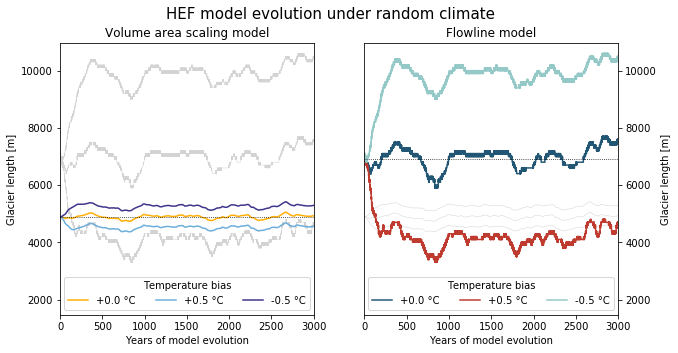

In [12]:
suptitle = 'HEF model evolution under random climate'
plot_time_series(ds, var='length', suptitle=suptitle, normalized=False)
plt.savefig('length_comparison_constant.pdf', bbox_inches='tight')

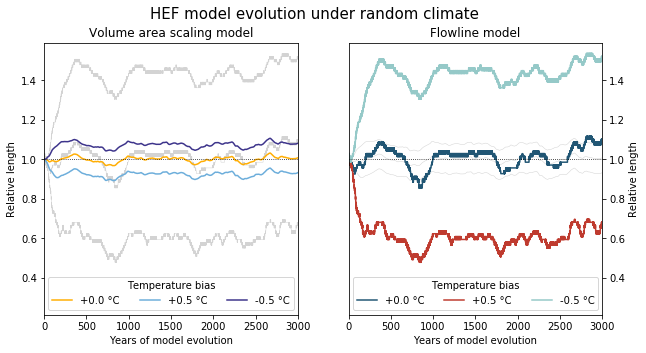

In [13]:
suptitle = 'HEF model evolution under random climate'
plot_time_series(ds_norm, var='length', suptitle=suptitle, normalized=True)
plt.savefig('length_norm_comparison_constant.pdf', bbox_inches='tight')

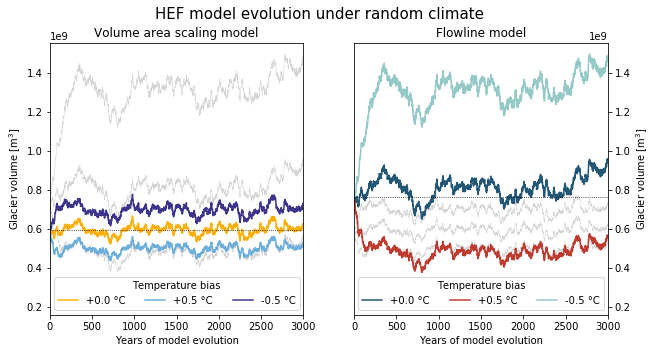

In [14]:
suptitle = 'HEF model evolution under random climate'
plot_time_series(ds, var='volume', suptitle=suptitle, normalized=False)
plt.savefig('volume_comparison_constant.pdf', bbox_inches='tight')

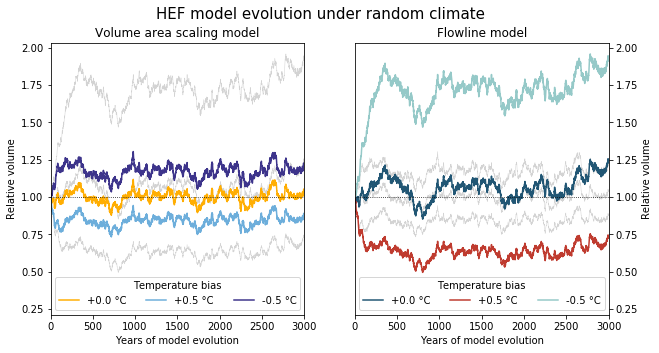

In [15]:
suptitle = 'HEF model evolution under random climate'
plot_time_series(ds_norm, var='volume', suptitle=suptitle, normalized=True)
# save plot to file
plt.savefig('volume_norm_comparison_constant.pdf', bbox_inches='tight')

### Plot time series in one panel

In [16]:
def plot_single_timeseries(ds, title='', ylabel=''):
    """
    """
    # plot relative volume change
    fig, ax = plt.subplots(1, 1, figsize=[7, 5])
    
    # set colors
    ax.set_prop_cycle('color', [vas_cycle[0], fl_cycle[0]])
    [ax.axhline(var_0, ls=':', lw=0.8, c='k') for var_0 in ds.sel(time=0).values]

    # flowline model
    handels = ds.plot(hue='model', add_legend=False)
    
    # labels, title, ...
    ax.set_title(title)
    ax.set_xlabel('Years of model evolution')
    ax.set_ylabel(ylabel)
    ax.legend(handels, ['vas', 'flowline'], title='Evolution model', ncol=2, loc=2)
    # axes
    ax.set_xlim([ds.time.min(), ds.time.max()])

In [474]:
# select single run
temp_bias = 0
# plot relative volume
plot_single_timeseries(ds_norm.volume.sel(temp_bias=temp_bias),
                       ylabel='Relative glacier volume',
                       title='HEF model glacier under random climate')
# add information about temperature bias
ax = plt.gca()
ax.text(0.95, 0.05, 'Temperature bias: {:+.1f} °C'.format(temp_bias),
        ha='right', va='center', transform=ax.transAxes)
# save plot to file
plt.savefig('volume_norm_constant.pdf', bbox_inches='tight')

NameError: name 'plot_single_timeseries' is not defined

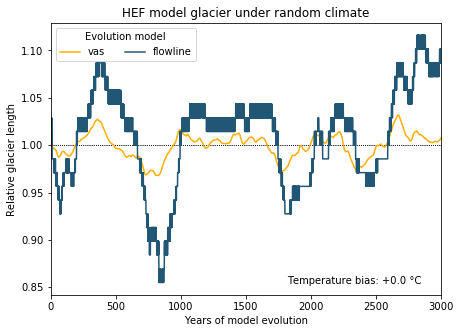

In [19]:
# plot relative length
plot_single_timeseries(ds_norm.length.sel(temp_bias=temp_bias),
                       ylabel='Relative glacier length',
                       title='HEF model glacier under random climate')
# add information about temperature bias
ax = plt.gca()
ax.text(0.95, 0.05, 'Temperature bias: {:+.1f} °C'.format(temp_bias),
        ha='right', va='center', transform=ax.transAxes)
# save plot to file
plt.savefig('length_norm_constant.pdf', bbox_inches='tight')

### Power spectrum

In [207]:
def plot_psd(ds, title=None, suptitle=''):
    
    # load module for the spectral analysis
    from scipy import signal
    
    # visualize the results
    fig, axes = plt.subplots(1, 3, figsize=(10, 6))
    plt.subplots_adjust(wspace=0.05)

    # prepare labels and titles
    temp_bias = ds.temp_bias.values
    if not title:
        title = np.repeat('', temp_bias.size)
    
    # prepare container for ylims
    ylim = list()

    for i, [b, ax] in enumerate(zip(temp_bias, axes)):
        # select values by temperature bias
        ds_tmp = ds.sel(temp_bias=b).length

        # compute the power of the signel per frequency band
        sig = ds_tmp.sel(model='fl').values.flatten()
        freqs, psd = signal.welch(sig)
        ax.loglog(freqs, psd, label='flowline', c=fl_cycle[0])

        # compute the power of the signel per frequency band
        sig = ds_tmp.sel(model='vas').values.flatten()
        freqs, psd = signal.welch(sig)
        ax.loglog(freqs, psd, label='vas', c=vas_cycle[0])

        ax.set_title(title[i])

        ax.grid(which='both')
        ylim.append(ax.get_ylim())
        # deal with labels
        ax.set_xlabel('Frequency [year$^{-1}$]')
        if i == 0:
            # add ylabel
            ax.set_ylabel('Power')
            # add legend
            ax.legend(loc=3)
        elif i == (axes.size - 1):
            # plot ticks and labels rigth on right panel
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_ylabel('Power')
        else:
            # remove ytick labels central (all other) pane
            ax.set_yticklabels([])
            
    # set y-limits equal for panel
    ylim = np.array(ylim).flatten()
    for ax in axes:
        ax.set_ylim([min(ylim), max(ylim)])
    
    
    # add suptitle
    fig.suptitle(suptitle, fontsize=15);

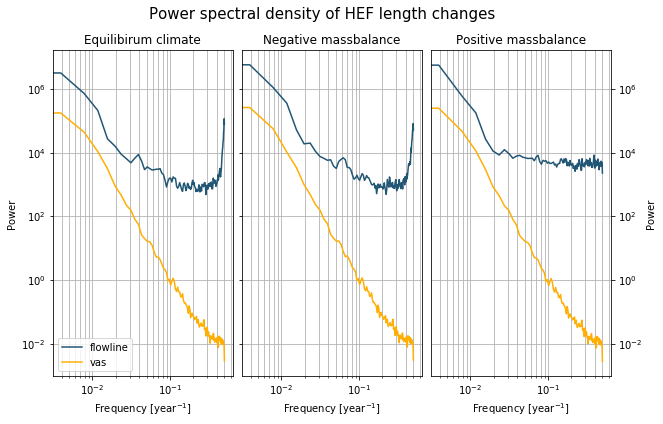

In [21]:
title = ['Equilibirum climate', 'Negative massbalance', 'Positive massbalance']
suptitle = 'Power spectral density of HEF length changes'
plot_psd(ds, title=title, suptitle=suptitle)

# save plot to file
plt.savefig('psd_length_random.pdf', bbox_inches='tight')

In [453]:
def plot_psd_semilog(ds, title=None, suptitle=''):
    
    # load module for the spectral analysis
    from scipy import signal
    
    # visualize the results
    fig, axes = plt.subplots(1, 3, figsize=(10, 6))
    plt.subplots_adjust(wspace=0.05)

    # prepare labels and titles
    temp_bias = ds.temp_bias.values
    if not title:
        title = np.repeat('', temp_bias.size)
    
    # prepare container for axes limits
    xlim = list()
    ylim = list()

    for i, [b, ax] in enumerate(zip(temp_bias, axes)):
        # select values by temperature bias
        ds_tmp = ds.sel(temp_bias=b).length

        # compute the power of the signel per frequency band
        sig = ds_tmp.sel(model='fl').values.flatten()
        freqs, psd = signal.welch(sig)
        ax.semilogy(freqs, psd, label='flowline', c=fl_cycle[0])

        # compute the power of the signel per frequency band
        sig = ds_tmp.sel(model='vas').values.flatten()
        freqs, psd = signal.welch(sig)
        ax.semilogy(freqs, psd, label='vas', c=vas_cycle[0])
        
        # set title
        ax.set_title(title[i])
        
        # get axes limits
        ax.grid(which='both')
        xlim.append(ax.get_xlim())
        ylim.append(ax.get_ylim())
        # deal with labels
        ax.set_xlabel('Repeat period [every X years]')
        if i == 0:
            # add ylabel
            ax.set_ylabel('Power')
            # add legend
            ax.legend(loc=3)
        elif i == (axes.size - 1):
            # plot ticks and labels rigth on right panel
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_ylabel('Power')
        else:
            # remove ytick labels central (all other) pane
            ax.set_yticklabels([])
            
    # set axes limits equal for panels
    xlim = np.array(xlim).flatten()
    ylim = np.array(ylim).flatten()
    from matplotlib import ticker
    for ax in axes:
        ax.set_xlim([min(xlim), max(xlim)])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax.set_ylim([min(ylim), max(ylim)])
        
    # change xticks from frequency to return period
    for ax in axes:
        xticks = ax.get_xticks()
        xticks = 1/xticks
        #xticks[np.where(np.isinf(xticks))] = 0
        ax.set_xticklabels(['{:.1f}'.format(tick) for tick in xticks])
        
    
    # add suptitle
    fig.suptitle(suptitle, fontsize=15)

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide


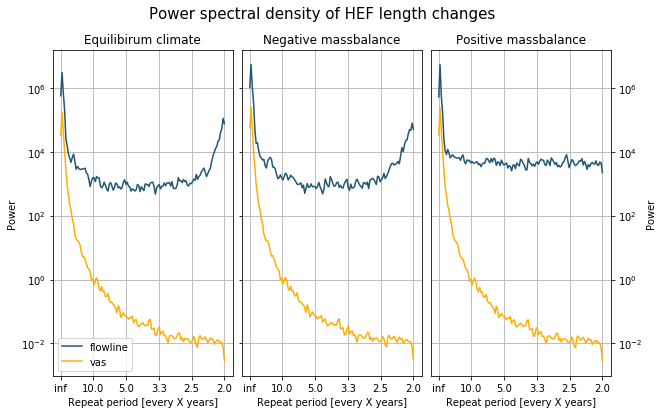

In [454]:
title = ['Equilibirum climate', 'Negative massbalance', 'Positive massbalance']
suptitle = 'Power spectral density of HEF length changes'
plot_psd_semilog(ds.sel(mb_model='random', normalized=False), title=title, suptitle=suptitle)

# save plot to file
plt.savefig('psd_length_random.pdf', bbox_inches='tight')